# Bruk av geopandas med data fra NVDB og SSB

Demo av hvordan geopandas kan brukes med data fra [Nasjonal vegdatabank](https://www.vegvesen.no/fag/teknologi/Nasjonal+vegdatabank) (NVDB) og [Statistisk Sentralbyrå](http://www.ssb.no/natur-og-miljo/geodata) (SSB). 

Vi ønsker å finne hvilke turistveger som går gjennom hvilke tettsteder - og hvilke trafikkulykker som er registrert der. 

Gangen er som følger: 
1. Last ned data over tettsteder fra [SSB](http://www.ssb.no/natur-og-miljo/geodata
1. Last ned turistveger fra [NVDB api](https://www.vegvesen.no/nvdb/apidokumentasjon/)
1. Finn snittet av turistveger og tettsteder (hvilke turistveger som går gjennom hvilke tettsteder)
1. Finn trafikkulykkene på turistvegene som går gjennom tettstedene. 
    1. Finn BoundingBox for hvert av tettstedene som har en turistveg gjennom seg.  
    1. Hent trafikkulykker innenfor BBox. 
    1. Finn trafikkulykkene som ligger på turistvegens senterlinje
        1. Alternativt finn trafikkulykkene innenfor radius fra turistvegen. 
1. Lag fine plott og sånn


# Kom i gang  

## Linux med anaconda


Last ned siste [Anaconda versjon](https://www.anaconda.com/download/#linux) for python 3.6 eller høyere, installer med ```bash Anaconda*.sh```- [Mer detaljert oppskrift](https://www.digitalocean.com/community/tutorials/how-to-install-the-anaconda-python-distribution-on-ubuntu-16-04). 

* Geopandas: Kluss med inkompatibilitet mellom hva Geopandas trenger og det som brukes default. 
  * ```conda config --add channels conda-forge``` (gir conda-forge høyest prioritet)
  * ```conda install -c conda-forge geopandas``` [Dokumentasjon](http://geopandas.org/install.html#installing-geopandas)
* Geojson ```conda install -c ioos geojson``` [Dokumentasjon](https://pypi.python.org/pypi/geojson)

## Linux uten anaconda

Antagelsen her er at du har python3 installert, men at din standard pythoninstallasjon er python 2.7.

* [Geopandas](http://geopandas.org/) ```pip3 install geopandas```
* [Geojson](https://pypi.python.org/pypi/geojson) ```pip3 install geojson```



## Windows 

Last ned og installer siste [Anaconda versjon](https://www.anaconda.com/download) for python 3.6 eller høyere. Kjør installasjonen. 

**Todo: Skriv om bruk av windows-oppfinnelsen _anaconda prompt_ **

# Last ned data fra SSB

Dette steget kan også gjøres manuelt. Direkte lenke for nedlasting av 2016-datasett er http://www.ssb.no/natur-og-miljo/_attachment/286736?_ts=158d3354ee0 

*NB! Det vil ikke overraske meg om lenkeråte gjør at du uansett må inn på SSB og finne nedlastingslenker* 

### Hent SSB-data manuelt 

1. Gå inn på http://www.ssb.no/natur-og-miljo/geodata#Nedlasting_av_datasett_med_dynamiske_avgrensinger . 
1. Klikk på *Nedlasting av kart over tettsteder*. 
1. Klikk på det året du vil laste ned for. 
    1. Nedlasting skal starte automagisk... hvis ikke kan du prøve en annen nettleser, evt kopiere lenken og bruke verktøy som curl eller wget. 
1. Pakk ut zip-arkivet og legg mappen ```Tettsted2016``` sammen med øvrige filer (rotnivå i repos'et). Dvs at stien til shapefilen skal være ```Tettsted2016/Tettsted2016.shp```







In [1]:
## Last ned SSB-data
# Se https://stackoverflow.com/a/14260592 , det om python 3+
import requests
import zipfile
import io
import os

url = 'http://www.ssb.no/natur-og-miljo/_attachment/286736?_ts=158d3354ee0'

# Laster kun en gang: 
if not os.path.exists('Tettsted2016/Tettsted2016.shp'):
    r = requests.get(url)
    if r.ok: 
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall()
    else: 
        print( "Nedlasting feiler:", r.status_code, r.reason )
        

# Importer de bibliotekene som trengs


In [2]:
import geopandas as gpd
import pandas as pd
import nvdbapi      # Fra https://github.com/LtGlahn/nvdbapi-V2
import nvdb2geojson # Fra https://github.com/LtGlahn/nvdbapi-V2

# Les data

In [3]:
tettsted = gpd.read_file( 'Tettsted2016/Tettsted2016.shp')
turistveger = nvdbapi.nvdbFagdata(777)
turistveger_geojson = nvdb2geojson.fagdata2geojson( turistveger)

/home/jansin/Documents/jobb/geopandas_ssb_nvdb_demo/nvdbapi.py:293: UserWarning: 
You should provide the file nvdbapi-clientinfo.json 
 
{ "X-Client" : "YOUR SYSTEM",
 "X-Kontaktperson" : "ola.nordmann@eposten.din" }

  warn( mytext )


In [4]:
turist2 = gpd.GeoDataFrame.from_features( turistveger_geojson['features'])

# Finn turistveger i tettsteder 

http://geopandas.org/mergingdata.html , spatial joins. 



In [5]:
tettsted.crs = {'init': 'epsg:25833'}
turist2.crs = {'init': 'epsg:25833'}

turist_i_tettsted = gpd.sjoin( turist2, tettsted, how='inner', op='intersects')
tettsted_m_turist = gpd.sjoin( tettsted, turist2, how='inner', op='intersects')


In [27]:
print( "Antall segmenter med turistveger", len( turist2))
print( "Antall tettsteder", len(tettsted))
print( "Tettsteder med turistveger", len(tettsted_m_turist), "FJERN DUPLIKATER?")
print( "Turistveger som går gjennom tettsteder", len(turist_i_tettsted))

Antall segmenter med turistveger 527
Antall tettsteder 990
Tettsteder med turistveger 120 FJERN DUPLIKATER?
Turistveger som går gjennom tettsteder 120


Våre 17 turistveger er splittet opp i 527 korte segmenter - og overgangen mellom segmentene er ofte i vegkryss, dvs vi har typisk mer enn ett turistveg-segment per tettsted. Det gir duplikater som må fjernes fra datasettet _tettsteder med turistveger_

In [29]:
tettsted_m_turist.drop_duplicates( subset='TETTNR', inplace=True)
print( "Tettsteder med turistveger", len(tettsted_m_turist), "UTEN duplikater")

Tettsteder med turistveger 44 UTEN duplikater


In [7]:
tettsted_m_turist.head(3)


,Tot_Bef,TETTNR,Tettstedsn,Areal_km2,Beff_tett,geometry,index_right,Link turistveg,Navn,Status,...,kortform,metadata,nummer,region,status,stedfesting,strekningslengde,til_meter,vegavdeling,vegsegment nr
76,261,4578,Nærland,0.257395,1014.007332,(POLYGON ((-46009.19449999917 6542647.40069999...,92,http://www.nasjonaleturistveger.no/no/jaeren,Jæren,Nasjonal turistveg,...,1100 Fv507 hp1 m14891-17983,"{'type': {'id': 777, 'navn': 'Turistveg'}, 've...",507,3,V,"{'veglenkeid': 319865, 'fra_posisjon': 0.61477...",3092,17983,11,2
138,7003,4631,Jørpeland,4.135783,1693.270709,(POLYGON ((-14439.73290000072 6578247.41059999...,160,http://www.nasjonaleturistveger.no/no/ryfylke,Ryfylke,Nasjonal turistveg,...,1100 Rv13 hp6 m10097-15567,"{'type': {'id': 777, 'navn': 'Turistveg'}, 've...",13,3,V,"{'veglenkeid': 320594, 'fra_posisjon': 0.0, 't...",5470,15567,11,61
138,7003,4631,Jørpeland,4.135783,1693.270709,(POLYGON ((-14439.73290000072 6578247.41059999...,161,http://www.nasjonaleturistveger.no/no/ryfylke,Ryfylke,Nasjonal turistveg,...,1100 Rv13 hp6 m15883-15893,"{'type': {'id': 777, 'navn': 'Turistveg'}, 've...",13,3,V,"{'veglenkeid': 2437537, 'fra_posisjon': 0.8858...",10,15893,11,62


In [8]:
turist_i_tettsted.head(3)

,Link turistveg,Navn,Status,antall vegsegmenter,fra_meter,fylke,geometry,hp,id,kategori,...,strekningslengde,til_meter,vegavdeling,vegsegment nr,index_right,Tot_Bef,TETTNR,Tettstedsn,Areal_km2,Beff_tett
11,http://www.nasjonaleturistveger.no/no/lofoten,Lofoten,Nasjonal turistveg,40,54,18,"LINESTRING Z (481851.5 7569211.71002 3.52, 481...",25,231728512,E,...,4647,4701,21,12,865,1794,7812,Kabelvåg,1.113858,1610.617537
22,http://www.nasjonaleturistveger.no/no/lofoten,Lofoten,Nasjonal turistveg,40,0,18,LINESTRING Z (478559.76025 7566856.00293 7.929...,26,231728512,E,...,5083,5083,21,23,865,1794,7812,Kabelvåg,1.113858,1610.617537
11,http://www.nasjonaleturistveger.no/no/lofoten,Lofoten,Nasjonal turistveg,40,54,18,"LINESTRING Z (481851.5 7569211.71002 3.52, 481...",25,231728512,E,...,4647,4701,21,12,866,4598,7814,Svolvær,2.377111,1934.280603


# Finner trafikkulykker på turistveger

Bruker NVDB api's overlappfilter https://www.vegvesen.no/nvdb/apidokumentasjon/#/parameter/overlappfilter 


In [9]:
ulykker = nvdbapi.nvdbFagdata( 570)
ulykker.addfilter_overlapp( '777'  )
print( 'Antall ulykker på turistveger', ulykker.statistikk()) 

/home/jansin/Documents/jobb/geopandas_ssb_nvdb_demo/nvdbapi.py:293: UserWarning: 
You should provide the file nvdbapi-clientinfo.json 
 
{ "X-Client" : "YOUR SYSTEM",
 "X-Kontaktperson" : "ola.nordmann@eposten.din" }

  warn( mytext )


Antall ulykker på turistveger {'antall': 4075, 'strekningslengde': 0}


In [10]:
ulykker_geojson = nvdb2geojson.fagdata2geojson( ulykker)
ulykker_gpd = gpd.GeoDataFrame.from_features( ulykker_geojson['features'])
ulykker_gpd.head(3)

,Alvorligste skadegrad,Antall alvorlig skadet,Antall drepte i ulykken,Antall enheter,Antall kjørefelt,Antall lettere skadet,Antall meget alvorlig skadet,Bebyggelse,Dekketype,Fartsgrense,...,kommune,kortform,metadata,meter,nummer,region,status,stedfesting,vegavdeling,vegsegment nr
0,Lettere skadd,0,0.0,1,2.0,1,0,Utenfor tettbebyggelse,"Asfalt, oljegrus",80.0,...,1418,1400 Fv55 hp14 m5478,"{'type': {'id': 570, 'navn': 'Trafikkulykke'},...",5478,55,3,V,"{'veglenkeid': 384522, 'posisjon': 0.559170149...",14,1
1,Alvorlig skadd,1,0.0,1,NaN,0,0,Utenfor tettbebyggelse,"Asfalt, oljegrus",80.0,...,1430,1400 Fv610 hp1 m16631,"{'type': {'id': 570, 'navn': 'Trafikkulykke'},...",16631,610,3,V,"{'veglenkeid': 384156, 'posisjon': 0.858920408...",14,1
2,Lettere skadd,0,0.0,1,2.0,1,0,Utenfor tettbebyggelse,"Asfalt, oljegrus",80.0,...,1418,1400 Fv55 hp14 m4724,"{'type': {'id': 570, 'navn': 'Trafikkulykke'},...",4724,55,3,V,"{'veglenkeid': 384522, 'posisjon': 0.482217336...",14,1


### Hvor mange av disse trafikkulykkene er i tettsteder? 

In [30]:
ulykker_gpd.crs = {'init': 'epsg:25833'}
# Spatial join gir kolonnene 'index_right' og 'index_left'. Disse må slettes eller døpes om 
# før resultatet fra spatial join brukes i nye joins
tettsted_m_turist.rename( columns={ 'index_right' : 'tettsted_m_turist_indeks_right'}, inplace=True)
ulykker_i_tettsted = gpd.sjoin( ulykker_gpd, tettsted_m_turist, how='inner', op='intersects')
ulykker_i_tettsted.shape

(649, 78)

In [19]:
junk = gpd.sjoin( ulykker_gpd, tettsted, how='inner', op='intersects')
junk.shape

(649, 57)

In [31]:
ulykker_i_tettsted.columns

Index(['Alvorligste skadegrad', 'Antall alvorlig skadet',
       'Antall drepte i ulykken', 'Antall enheter', 'Antall kjørefelt',
       'Antall lettere skadet', 'Antall meget alvorlig skadet', 'Bebyggelse',
       'Dekketype', 'Fartsgrense', 'Felttype', 'Forsterket vegoppmerking',
       'Føreforhold', 'Geometri, punkt', 'Historisk hp',
       'Historisk kilometerverdi', 'Historisk vegkategori',
       'Historisk vegnummer', 'Historisk vegstatus', 'Kommunenr', 'Lysforhold',
       'Midtdeler', 'Registreringsdato for fagdata',
       'Stedfestingens nøyaktighet', 'Stedsforhold', 'Temperatur',
       'Uhell kategori', 'Uhellskode', 'Ukedag', 'Ulykkesdato',
       'Ulykkestidspunkt', 'Vegbredde', 'Vegnavn', 'Vegtype', 'Værforhold',
       'antall vegsegmenter_left', 'fylke_left', 'geometry', 'hp_left',
       'id_left', 'kategori_left', 'kommune_left', 'kortform_left',
       'metadata_left', 'meter', 'nummer_left', 'region_left', 'status_left',
       'stedfesting_left', 'vegavdeling_le

In [14]:
%matplotlib inline
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

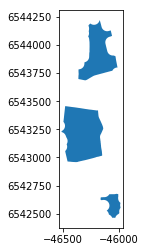

In [15]:
tettsted_m_turist[ tettsted_m_turist.TETTNR == '4578'].geometry.plot()


In [22]:
ulykker_i_tettsted.geometry.head()

8               POINT Z (89272.83984 6831871.18994 2.98)
98           POINT Z (89542.36386 6831112.47493 2.52845)
112    POINT Z (89322.36126000001 6831828.35874 2.85016)
137           POINT Z (89373.62676 6831765.62907 2.8322)
138          POINT Z (89435.66747 6831494.08702 3.49889)
Name: geometry, dtype: object

In [17]:
# Dumper til fil: 

with open('ulykker.json', 'w') as f:
    f.write(ulykker_gpd.to_json())
    
with open('tettsted_m_turist.json', 'w') as f:
    f.write(tettsted_m_turist.to_json())

In [23]:
with open('ulykker_litenJoin.geojson', 'w') as f:
    f.write(junk.to_json())
    
with open('ulykker_storJoin.geojson', 'w') as f:
    f.write(ulykker_i_tettsted.to_json())

In [26]:
# fjerner duplikater? 
tettsted_m_turist[ tettsted_m_turist.Tettstedsn == 'Tyssedal' ]

,Tot_Bef,TETTNR,Tettstedsn,Areal_km2,Beff_tett,geometry,tettsted_m_turist_indeks_right,Link turistveg,Navn,Status,...,kortform,metadata,nummer,region,status,stedfesting,strekningslengde,til_meter,vegavdeling,vegsegment nr
index_right,,,,,,,,,,,,,,,,,,,,,
404,620,5093,Tyssedal,0.623732,994.016865,"POLYGON ((31611.71229999978 6695084.5956, 3161...",429,http://www.nasjonaleturistveger.no/no/hardanger,Hardanger,Nasjonal turistveg,...,1200 Rv13 hp5 m0-4944,"{'type': {'id': 777, 'navn': 'Turistveg'}, 've...",13,3,V,"{'veglenkeid': 805649, 'fra_posisjon': 0.0, 't...",4944,4944,12,67
404,620,5093,Tyssedal,0.623732,994.016865,"POLYGON ((31611.71229999978 6695084.5956, 3161...",434,http://www.nasjonaleturistveger.no/no/hardanger,Hardanger,Nasjonal turistveg,...,1200 Rv13 hp5 m4944-4956,"{'type': {'id': 777, 'navn': 'Turistveg'}, 've...",13,3,V,"{'veglenkeid': 805649, 'fra_posisjon': 0.58546...",12,4956,12,72
404,620,5093,Tyssedal,0.623732,994.016865,"POLYGON ((31611.71229999978 6695084.5956, 3161...",435,http://www.nasjonaleturistveger.no/no/hardanger,Hardanger,Nasjonal turistveg,...,1200 Rv13 hp5 m4956-5094,"{'type': {'id': 777, 'navn': 'Turistveg'}, 've...",13,3,V,"{'veglenkeid': 805649, 'fra_posisjon': 0.58693...",138,5094,12,73
404,620,5093,Tyssedal,0.623732,994.016865,"POLYGON ((31611.71229999978 6695084.5956, 3161...",364,http://www.nasjonaleturistveger.no/no/hardanger,Hardanger,Nasjonal turistveg,...,1200 Rv13 hp5 m5094-5147,"{'type': {'id': 777, 'navn': 'Turistveg'}, 've...",13,3,V,"{'veglenkeid': 805649, 'fra_posisjon': 0.60326...",52,5147,12,2
404,620,5093,Tyssedal,0.623732,994.016865,"POLYGON ((31611.71229999978 6695084.5956, 3161...",365,http://www.nasjonaleturistveger.no/no/hardanger,Hardanger,Nasjonal turistveg,...,1200 Rv13 hp5 m5147-5592,"{'type': {'id': 777, 'navn': 'Turistveg'}, 've...",13,3,V,"{'veglenkeid': 805649, 'fra_posisjon': 0.60945...",445,5592,12,3
